In [482]:
DATA_SOURCE = "https://data.heatonresearch.com/data/t81-558/auto-mpg.csv"; TARGET = "mpg";IS_REGRESSION=True
# DATA_SOURCE = "https://data.heatonresearch.com/data/t81-558/iris.csv"; TARGET = "species";IS_REGRESSION=False
# DATA_SOURCE = "https://data.heatonresearch.com/data/t81-558/crx.csv"; TARGET = 'a16'; IS_REGRESSION=False

In [483]:
import pandas as pd
from pydantic import BaseModel
from scipy.stats import shapiro
import scipy.stats as stats
import numpy as np



In [484]:
df = pd.read_csv(DATA_SOURCE)
df.head(5)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


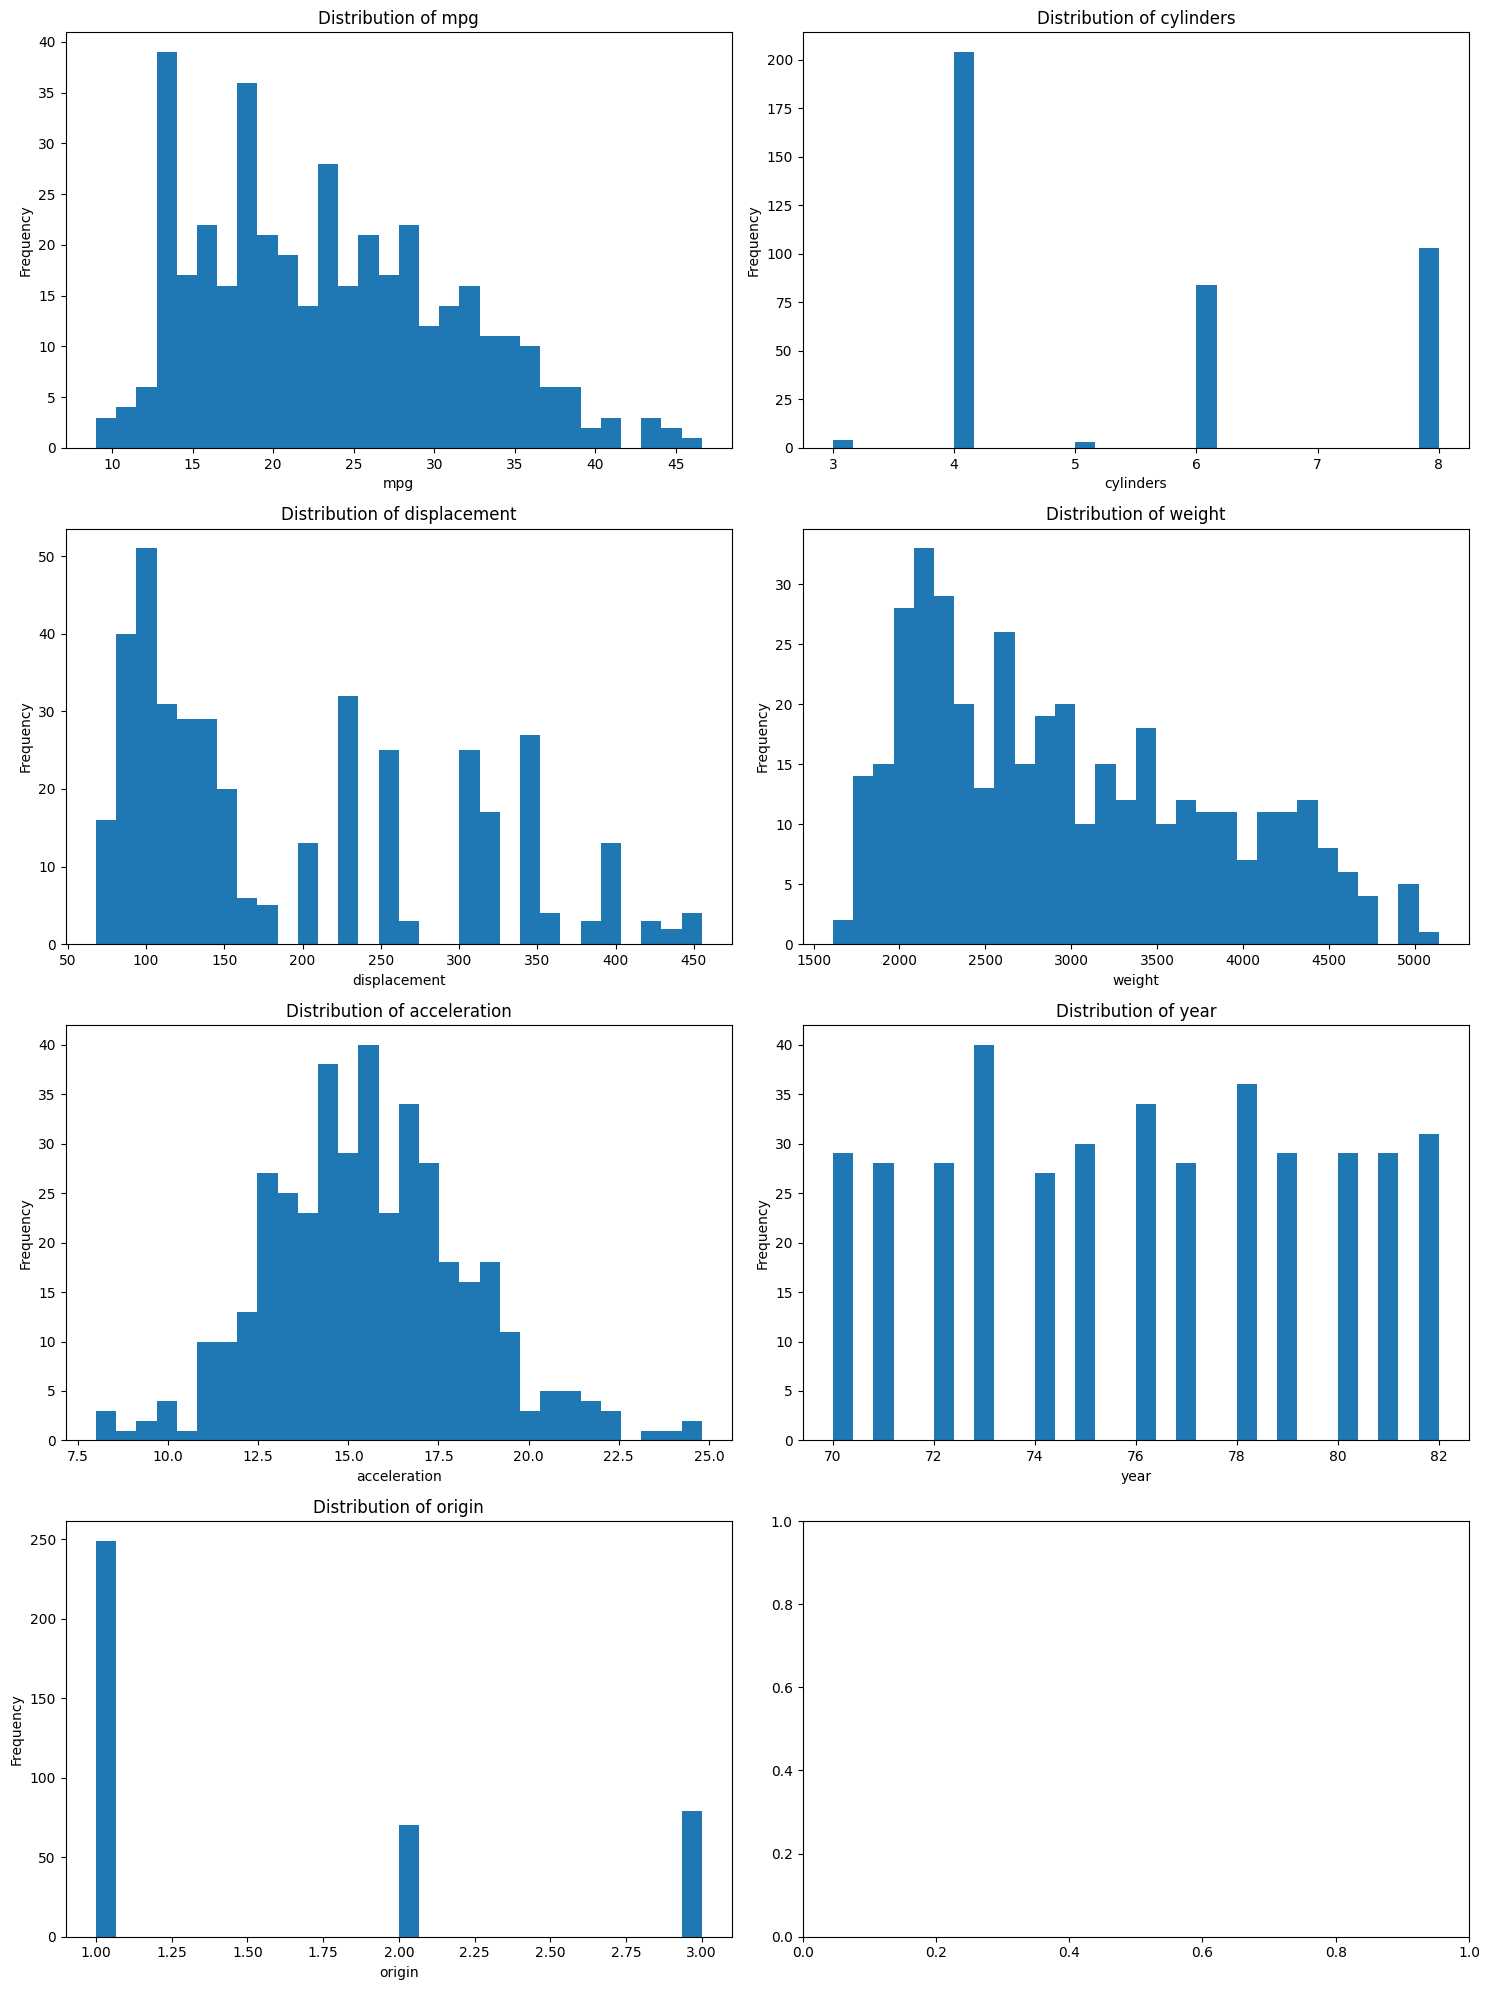

In [485]:
import matplotlib.pyplot as plt

# Create a figure with subplots for each numeric column
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
num_cols = len(numeric_columns)
fig, axes = plt.subplots(nrows=(num_cols+1)//2, ncols=2, figsize=(15, 5*(num_cols+1)//2))
axes = axes.ravel()

# Plot each numeric column
for idx, col in enumerate(numeric_columns):
    axes[idx].hist(df[col], bins=30)
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')

# Adjust layout and display
plt.tight_layout()
plt.show()

In [486]:
def isnumeric(datatype):
  return datatype in ["int","float"]

In [487]:
def find_positive(s):
  s = set(s.str.upper().tolist())
  if len(s) != 2: return None
  if "+" in s and "-" in s: return "+"
  if "0" in s and "1" in s: return "1"
  if "t" in s and "f" in s: return "t"
  if "y" in s and "n" in s: return "y"
  if "true" in s and "false" in s: return "true"
  if "yes" in s and "no" in s: return "yes"
  if "p" in s and "n" in s: return "p"
  if "positive" in s and "negative" in s: return "positive"
  s = list(s)
  s.sort()
  return s[0]


In [488]:
CONFIG_MAX_DUMMY = "max_dummy"
CONFIG_MAX_DUMMY_PCT = "pct_dummy"
CONFIG = {
  CONFIG_MAX_DUMMY: 1000,
  CONFIG_MAX_DUMMY_PCT: 0.75
}
metadata = {

}
# metadata = analyze(DATA_SOURCE, TARGET, IS_REGRESSION)

def create_metadata(DATA_SOURCE, TARGET, IS_REGRESSION):

    fields = {'fields' : {}}
    for col,col_type in zip(df.columns,df.dtypes):
        
        if "float" in col_type.name:
            dtype = "float"

        elif "int" in col_type.name:
            dtype = "int"
        else:
            dtype = "str"


        if isnumeric(df[col].dtype):
            stats, p = shapiro(df[col])
            
            action = "zscore" if p>0.05 else "normalize"
    



            # print(dtype)
            fields['fields'][col] = {
                'type': dtype ,
                'median' : df[col].median(),
                
                'mean' : df[col].mean(),
                'sd' : df[col].std(),
                
                'max' : df[col].max(),
                'min' : df[col].min(),
                'shapiro-stat': stats,
                'shapiro-p': p,
                'action': action,
                'missing': int(df[col].isnull().sum()),
                'unique': int(df[col].nunique())

                }
        else:
        
            fields['fields'][col] = {
                'type': dtype ,
                'mode' : df[col].mode()[0],
                'action': 'copy',
                'missing': int(df[col].isnull().sum()),
                'unique': int(df[col].nunique()),
            
                }
            
            # Determine action
        field = fields['fields'][col]
        if (field["type"] == "str") and (field["unique"]<CONFIG[CONFIG_MAX_DUMMY]) and (field["unique"]/len(df)<CONFIG[CONFIG_MAX_DUMMY_PCT]):
            field["action"] =  "dummy"
        if col == TARGET :
            field["action"] = "target"
    


    metadata.update(fields)
    metadata.update({ 'target' : TARGET ,'source':DATA_SOURCE ,  'early-stop': False, 'type' : 'classification'})


    
    if IS_REGRESSION:
        metadata.update({'type' : 'regression'})
    else:
        if metadata["fields"][TARGET]["unique"]==2:
            metadata.update({'type' : 'binary-classification'})
            metadata.update({'positive-token' : find_positive(df[TARGET]) })
        else:
            metadata.update({'type' : 'classification'})


    return metadata

In [489]:
COLS = ['mean', 'sd', 'median', 'mode', 'max', 'action', 'unique', 'shapiro_p', 'missing']


def field_summary(metadata, cols=COLS):
  data = {}

  data['name'] = []
  for col in cols:
    data[col] = []

  for field_name in metadata["fields"]:
    field = metadata["fields"][field_name]
    data['name'].append(field_name)
    for col in cols:
      data[col].append(field.get(col, None))

  return pd.DataFrame(data)[['name']+COLS]  

In [ ]:
import pandas as pd

def filter_dtype(df, threshold=0.8):
    df = df.copy()  
    
    for col in df.columns:
        if df[col].dtype == object: 
            numeric_col = pd.to_numeric(df[col], errors='coerce')
            numeric_count = numeric_col.notna().sum()
            string_count = len(df[col]) - numeric_count

            if numeric_count > 0:
                if string_count > len(df[col]) * threshold:
                    df[col] = df[col].astype(str)  
                else:
                    df[col] = numeric_col  

    
    df.dropna(inplace=True)  
    
    return df

# Example usage
df = filter_dtype(df)
print(df.info())
print(df['horsepower'].isna().sum())  


<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
 8   name          392 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB
None
0


In [491]:
metadata = create_metadata( DATA_SOURCE , TARGET , IS_REGRESSION )
field_summary(metadata)
# metadata

,name,mean,sd,median,mode,max,action,unique,shapiro_p,missing
0,mpg,23.445918,7.805007,22.75,None,46.6,target,127,None,0
1,cylinders,NaN,NaN,NaN,4,NaN,copy,5,None,0
2,displacement,194.411990,104.644004,151.00,None,455.0,normalize,81,None,0
3,horsepower,104.469388,38.491160,93.50,None,230.0,normalize,93,None,0
4,weight,NaN,NaN,NaN,1985,NaN,copy,346,None,0
5,acceleration,15.541327,2.758864,15.50,None,24.8,normalize,95,None,0
6,year,NaN,NaN,NaN,73,NaN,copy,13,None,0
7,origin,NaN,NaN,NaN,1,NaN,copy,3,None,0
8,name,NaN,NaN,NaN,amc matador,NaN,copy,301,None,0


In [492]:
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52.0,2130,24.6,82,2,vw pickup
395,32.0,4,135.0,84.0,2295,11.6,82,1,dodge rampage
396,28.0,4,120.0,79.0,2625,18.6,82,1,ford ranger


In [493]:
metadata

{'fields': {'mpg': {'type': 'float',
   'median': 22.75,
   'mean': 23.445918367346938,
   'sd': 7.8050074865717995,
   'max': 46.6,
   'min': 9.0,
   'shapiro-stat': 0.9671696219782999,
   'shapiro-p': 1.0494407063380879e-07,
   'action': 'target',
   'missing': 0,
   'unique': 127},
  'cylinders': {'type': 'int',
   'mode': 4,
   'action': 'copy',
   'missing': 0,
   'unique': 5},
  'displacement': {'type': 'float',
   'median': 151.0,
   'mean': 194.41198979591837,
   'sd': 104.64400390890466,
   'max': 455.0,
   'min': 68.0,
   'shapiro-stat': 0.8818359417766902,
   'shapiro-p': 8.983637114586926e-17,
   'action': 'normalize',
   'missing': 0,
   'unique': 81},
  'horsepower': {'type': 'float',
   'median': 93.5,
   'mean': 104.46938775510205,
   'sd': 38.49115993282849,
   'max': 230.0,
   'min': 46.0,
   'shapiro-stat': 0.9040974881446464,
   'shapiro-p': 5.0220692907916354e-15,
   'action': 'normalize',
   'missing': 0,
   'unique': 93},
  'weight': {'type': 'int',
   'mode': 19

In [494]:
def genrate_keras_model():
    pass

In [495]:
# import pandas as pd
# import io
# import requests
# import numpy as np
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Activation
# from tensorflow.keras.callbacks import EarlyStopping
# from scipy.stats import zscore
# from sklearn.preprocessing import MinMaxScaler
# from sklearn import metrics
# from sklearn.metrics import accuracy_score


# df = pd.read_csv("https://data.heatonresearch.com/data/t81-558/iris.csv", na_values=['NA', '?'])


# x_fields = []

# df["sepal_l"] = MinMaxScaler().fit_transform(df[['sepal_l']])

# x_fields.append("sepal_l")

# df["sepal_w"] = zscore(df["sepal_w"])

# x_fields.append("sepal_w")

# df["petal_l"] = MinMaxScaler().fit_transform(df[['petal_l']])

# x_fields.append("petal_l")

# df["petal_w"] = MinMaxScaler().fit_transform(df[['petal_w']])

# x_fields.append("petal_w")



# x = df[x_fields].values

# dummies = pd.get_dummies(df["species"])

# species = dummies.columns

# y = dummies.values


# print(dummies)

# # # Construct model
# # model = Sequential()
# # model.add(Dense(50, input_dim=x.shape[1], activation="relu"))
# # model.add(Dense(25, activation="relu"))
# # model.add(Dense(y.shape[1], activation="softmax"))
# # model.compile(loss="categorical_crossentropy", optimizer="adam")

# # # Train model
# # model.fit(x, y, verbose=2, epochs=100)


# # # Evaluate model
# # pred = model.predict(x)
# # predict_classes = np.argmax(pred, axis=1)
# # expected_classes = np.argmax(y, axis=1)
# # correct = accuracy_score(expected_classes, predict_classes)

# # print(f"Accuracy: {correct}")


# # score = metrics.log_loss(y, pred )



# # print(f"Log loss: {score}")


In [496]:


# print(find_positive(df[TARGET]))


In [497]:
# import pandas as pd
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.experimental import enable_iterative_imputer  # Enables IterativeImputer
# from sklearn.impute import IterativeImputer

# # Load dataset
# df = pd.read_csv('creditscore.csv')

# # Select only numerical columns (IterativeImputer works only on numerical data)
# df_numeric = df.select_dtypes(include=['number'])

# # Define pipeline
# pipeline = Pipeline([
#     ('imputer', IterativeImputer()),  # Automatically fills NaN
#     ('scaler', MinMaxScaler())  # Scales data
# ])

# # Transform data
# df_transformed = pipeline.fit_transform(df_numeric)

# # Convert back to DataFrame with original column names
# df_transformed = pd.DataFrame(df_transformed, columns=df_numeric.columns)

# # If original dataframe had categorical columns, concatenate them back
# df_final = pd.concat([df_transformed, df.select_dtypes(exclude=['number'])], axis=1)

# # Display result
# df_final.head()


In [498]:

df_final.isna().sum()


NameError: name 'df_final' is not defined

In [ ]:
# import pandas as pd
# import io
# import requests
# import numpy as np
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Activation
# from tensorflow.keras.callbacks import EarlyStopping
# from scipy.stats import zscore
# from sklearn.preprocessing import MinMaxScaler
# from sklearn import metrics
# from sklearn.metrics import accuracy_score
# df = pd.read_csv("https://data.heatonresearch.com/data/t81-558/crx.csv", na_values=['NA', '?'])
# x_fields = ['a11', 'a15']
# dummies = pd.get_dummies(df["a1"], prefix="a1", drop_first=True)
# df = pd.concat([df,dummies],axis=1)
# x_fields += dummies.columns.tolist()
# dummies = pd.get_dummies(df["a2"], prefix="a2", drop_first=True)
# df = pd.concat([df,dummies],axis=1)
# x_fields += dummies.columns.tolist()
# df["s3"] = MinMaxScaler().fit_transform(df[['s3']])
# x_fields.append("s3")
# dummies = pd.get_dummies(df["a4"], prefix="a4", drop_first=True)
# df = pd.concat([df,dummies],axis=1)
# x_fields += dummies.columns.tolist()
# dummies = pd.get_dummies(df["a5"], prefix="a5", drop_first=True)
# df = pd.concat([df,dummies],axis=1)
# x_fields += dummies.columns.tolist()
# dummies = pd.get_dummies(df["a6"], prefix="a6", drop_first=True)
# df = pd.concat([df,dummies],axis=1)
# x_fields += dummies.columns.tolist()
# dummies = pd.get_dummies(df["a7"], prefix="a7", drop_first=True)
# df = pd.concat([df,dummies],axis=1)
# x_fields += dummies.columns.tolist()
# df["a8"] = MinMaxScaler().fit_transform(df[['a8']])
# x_fields.append("a8")
# dummies = pd.get_dummies(df["a9"], prefix="a9", drop_first=True)
# df = pd.concat([df,dummies],axis=1)
# x_fields += dummies.columns.tolist()
# dummies = pd.get_dummies(df["a10"], prefix="a10", drop_first=True)
# df = pd.concat([df,dummies],axis=1)
# x_fields += dummies.columns.tolist()
# dummies = pd.get_dummies(df["a12"], prefix="a12", drop_first=True)
# df = pd.concat([df,dummies],axis=1)
# x_fields += dummies.columns.tolist()
# dummies = pd.get_dummies(df["a13"], prefix="a13", drop_first=True)
# df = pd.concat([df,dummies],axis=1)
# x_fields += dummies.columns.tolist()
# dummies = pd.get_dummies(df["a14"], prefix="a14", drop_first=True)
# df = pd.concat([df,dummies],axis=1)
# x_fields += dummies.columns.tolist()
# x = df[x_fields].values
# df["a16"] = (df["a16"]=="+").astype(int)
# y = df.a16.values
# # Construct model
# model = Sequential()
# model.add(Dense(50, input_dim=x.shape[1], activation="relu"))
# model.add(Dense(25, activation="relu"))
# model.add(Dense(1, activation="sigmoid"))
# model.compile(loss="binary_crossentropy", optimizer="adam")
# # Train model
# model.fit(x, y, verbose=2, epochs=100)
# # Evaluate model
# pred = model.predict(x)
# predict_classes = np.argmax(pred, axis=1)
# correct = accuracy_score(y, predict_classes)
# print(f"Accuracy: {correct}")
# fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
# score = metrics.auc(fpr, tpr)
# print(f"Area Under Curve: {score}")
# score = metrics.log_loss(y, pred, eps=1e-07)
# print(f"Log loss: {score}")
